In [1]:
import os
import cv2
import random
import contextlib
import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
import matplotlib.patches as patches

#torch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


#To parse xml files
!pip install xmltodict
import xmltodict

In [2]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [3]:
!unzip -qq "/content/drive/MyDrive/Project Deals/Pattern_Recognition/Project/Data/archive.zip"

In [4]:
image_path="/content/images/"
ann_path="/content/annotations/"

save_folder="/content/drive/MyDrive/Project Deals/Pattern_Recognition/Project/weight"

In [5]:
name_to_label={"with_mask":0,"without_mask":1,"mask_weared_incorrect":2}
label_to_name={label:name for name,label in name_to_label.items()}

In [6]:
num_classes=3

In [7]:
def plot_image(img_tensor, annotation):

    fig,ax = plt.subplots(1)
    img = img_tensor.cpu().data

    # Display the image
    ax.imshow(img.permute(1, 2, 0))

    for box,label in zip(annotation["boxes"],annotation["labels"]):
        xmin, ymin, xmax, ymax = box

        # Create a Rectangle patch
        mpatch = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        val=label.item()
        rx, ry = mpatch.get_xy()
        ax.annotate(label_to_name[val], (rx, ry),color="green", weight='bold', fontsize=10, ha='left', va='baseline')
        # Add the patch to the Axes
        ax.add_patch(mpatch)

    plt.show()

#Load Data for Object detection model

In [8]:
#Load image paths
image_names=os.listdir(image_path)
#Load annotations paths
ann_names=os.listdir(ann_path)

In [9]:
image_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

In [10]:
def dataset_from_files(image_names):
  image_tensor=[]
  label_tensor=[]
  for i,j in enumerate(image_names):
    with open(os.path.join(ann_path,j[:-4]+".xml")) as fd:
        xml_obj=xmltodict.parse(fd.read())

    if type(xml_obj["annotation"]["object"])!=list:
      xml_obj["annotation"]["object"]=[xml_obj["annotation"]["object"]]

    image=Image.open(os.path.join(image_path,j)).convert("RGB")
    image_tensor.append(image_transform(image))
    annotation={}
    annotation["boxes"]=[list(map(int,ann_ind["bndbox"].values())) for ann_ind in xml_obj["annotation"]["object"]]
    annotation["boxes"]=torch.as_tensor(annotation["boxes"], dtype=torch.float32)
    annotation["labels"]=[name_to_label[ann_ind["name"]] for ann_ind in xml_obj["annotation"]["object"]]
    annotation["labels"]=torch.as_tensor(annotation["labels"], dtype=torch.int64)
    label_tensor.append(annotation)
  final_dataset=[[k,l] for k,l in zip(image_tensor,label_tensor)]
  return tuple(final_dataset)

In [11]:
collate_fn = lambda batch: tuple(zip(*batch))

In [12]:
mydataset=dataset_from_files(image_names)
# mydataset=MaskDataset()
train_size=int(len(mydataset)*0.95)
test_size=len(mydataset)-train_size
print('Length of dataset is', len(mydataset), '\nLength of training set is :',train_size,'\nLength of test set is :', test_size)

Length of dataset is 853 
Length of training set is : 810 
Length of test set is : 43


In [13]:
trainset,testset=torch.utils.data.random_split(mydataset,[train_size,test_size])

In [14]:
train_dataloader = DataLoader(dataset=trainset,batch_size=4,shuffle=True,num_workers=1,collate_fn=collate_fn)
test_dataloader = DataLoader(dataset=testset,batch_size=4,shuffle=True,num_workers=1,collate_fn=collate_fn)

# Model Training

In [15]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [16]:
def train_transfer(num_epochs,model,optimizer):
  Train_loss=[]
  for epoch in tqdm(range(num_epochs)):
      train_loss = 0.0
      val_loss = 0.0
      train_total = 0
      val_total = 0
      train_correct = 0
      val_correct =0

      for i, (images, annotations) in enumerate(train_dataloader):
        images = list(image.to(device) for image in images)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        # labels = labels.to(device)

        # Forward pass
        loss_dict = model(images, annotations)
        loss_classifier = loss_dict['loss_classifier']
        loss_box_reg = loss_dict['loss_box_reg']
        loss = loss_classifier + loss_box_reg

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * len(images)

      train_loss = train_loss / len(train_dataloader.dataset)

      #Appending value at each epoch
      Train_loss.append(train_loss)

      print(f"Epoch [{epoch+1}/{num_epochs}] : Train Loss: {train_loss:.4f}")
  info=[Train_loss]
  return model,info

##Fastrcnn with resnet50_fpn

In [17]:
model = models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#Load the model to gpu if present
model_fcnn=model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 318MB/s]


In [18]:
num_epochs = 25
params = [p for p in model.parameters() if p.requires_grad]
optimizer_fcnn = torch.optim.Adam(params, lr=0.0001)
# optimizer = torch.optim.SGD(params, lr=0.0001,momentum=0.9)

In [19]:
model_fcnn,model_fcnn_info=train_transfer(num_epochs,model_fcnn,optimizer_fcnn)

  4%|▍         | 1/25 [04:18<1:43:15, 258.16s/it]

Epoch [1/25] : Train Loss: 0.0971


  8%|▊         | 2/25 [08:39<1:39:37, 259.89s/it]

Epoch [2/25] : Train Loss: 0.0784


 12%|█▏        | 3/25 [12:56<1:34:49, 258.62s/it]

Epoch [3/25] : Train Loss: 0.0657


 16%|█▌        | 4/25 [17:11<1:30:02, 257.27s/it]

Epoch [4/25] : Train Loss: 0.0591


 20%|██        | 5/25 [21:29<1:25:48, 257.44s/it]

Epoch [5/25] : Train Loss: 0.0478


 24%|██▍       | 6/25 [25:45<1:21:26, 257.16s/it]

Epoch [6/25] : Train Loss: 0.0402


 28%|██▊       | 7/25 [30:03<1:17:08, 257.14s/it]

Epoch [7/25] : Train Loss: 0.0361


 32%|███▏      | 8/25 [34:22<1:13:02, 257.77s/it]

Epoch [8/25] : Train Loss: 0.0361


 36%|███▌      | 9/25 [38:40<1:08:47, 257.94s/it]

Epoch [9/25] : Train Loss: 0.0295


 40%|████      | 10/25 [42:59<1:04:35, 258.38s/it]

Epoch [10/25] : Train Loss: 0.0275


 44%|████▍     | 11/25 [47:17<1:00:13, 258.13s/it]

Epoch [11/25] : Train Loss: 0.0265


 48%|████▊     | 12/25 [51:35<55:56, 258.21s/it]  

Epoch [12/25] : Train Loss: 0.0250


 52%|█████▏    | 13/25 [55:53<51:36, 258.08s/it]

Epoch [13/25] : Train Loss: 0.0267


 56%|█████▌    | 14/25 [1:00:12<47:22, 258.45s/it]

Epoch [14/25] : Train Loss: 0.0287


 60%|██████    | 15/25 [1:04:28<42:55, 257.57s/it]

Epoch [15/25] : Train Loss: 0.0253


 64%|██████▍   | 16/25 [1:08:46<38:38, 257.64s/it]

Epoch [16/25] : Train Loss: 0.0239


 68%|██████▊   | 17/25 [1:13:04<34:22, 257.87s/it]

Epoch [17/25] : Train Loss: 0.0223


 72%|███████▏  | 18/25 [1:17:22<30:04, 257.81s/it]

Epoch [18/25] : Train Loss: 0.0240


 76%|███████▌  | 19/25 [1:21:36<25:39, 256.63s/it]

Epoch [19/25] : Train Loss: 0.0226


 80%|████████  | 20/25 [1:25:53<21:24, 256.94s/it]

Epoch [20/25] : Train Loss: 0.0227


 84%|████████▍ | 21/25 [1:30:08<17:05, 256.31s/it]

Epoch [21/25] : Train Loss: 0.0198


 88%|████████▊ | 22/25 [1:34:24<12:48, 256.31s/it]

Epoch [22/25] : Train Loss: 0.0199


 92%|█████████▏| 23/25 [1:38:40<08:32, 256.07s/it]

Epoch [23/25] : Train Loss: 0.0192


 96%|█████████▌| 24/25 [1:42:58<04:16, 256.54s/it]

Epoch [24/25] : Train Loss: 0.0182


100%|██████████| 25/25 [1:47:17<00:00, 257.50s/it]

Epoch [25/25] : Train Loss: 0.0195


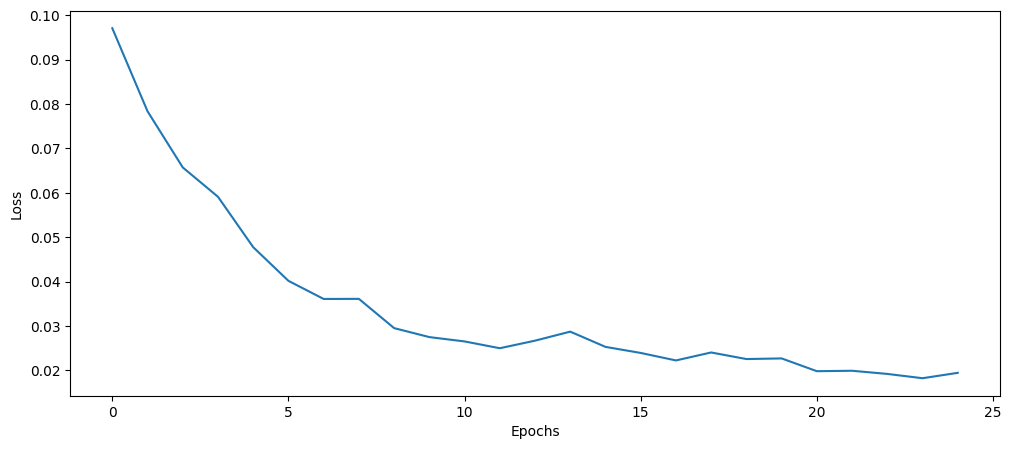

In [21]:
fig, axs = plt.subplots(1,figsize=(12,5))

x_axis=range(len(model_fcnn_info[0]))
axs.plot(x_axis,model_fcnn_info[0])
axs.set(ylabel="Loss")
axs.set(xlabel="Epochs")

plt.show()

#Model inference

In [ ]:
torch.save(model_fcnn,os.path.join(save_folder,"fcnn.pickle"))

In [ ]:
# model_fcnn=torch.load(os.path.join(save_folder,"fcnn.pickle"))

In [61]:
for imgs, annotations in train_dataloader:
  imgs = list(img.to(device) for img in imgs)
  test_img=(imgs[1].unsqueeze(dim=0))
  test_annotations=annotations[1]
  break
model_fcnn.eval()
preds = model_fcnn(test_img)

In [62]:
preds={k:v.cpu().detach().numpy() for k,v in preds[0].items()}

Prediction


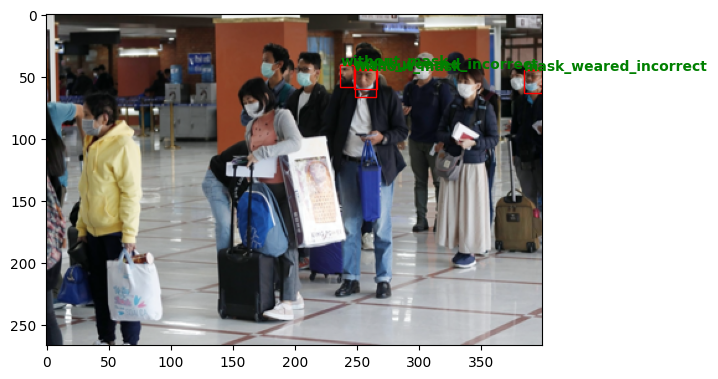

Target


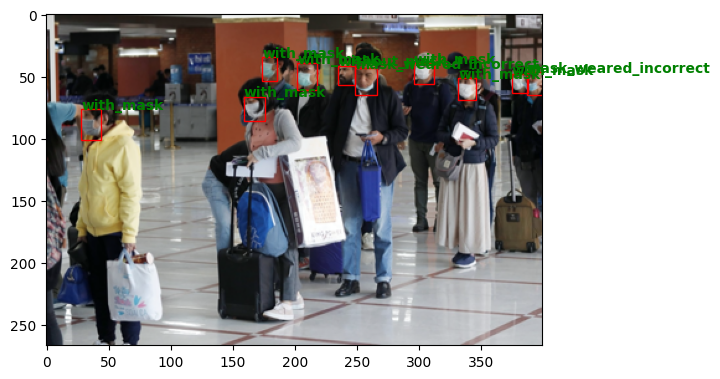

In [30]:
print("Prediction")
plot_image(test_img[0], preds)
print("Target")
plot_image(test_img[0], test_annotations)

Prediction


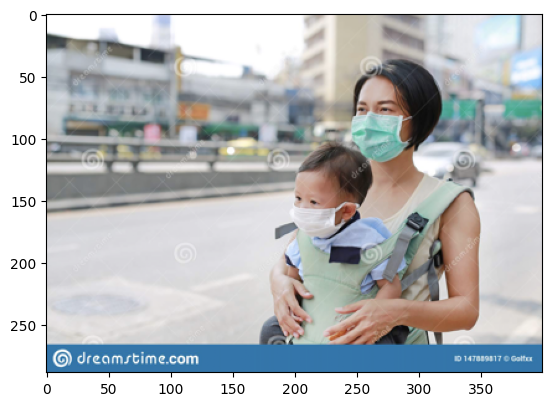

Target


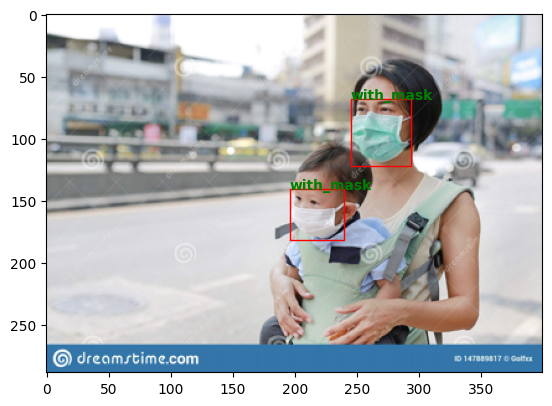

In [ ]:
print("Prediction")
plot_image(test_img[0], preds)
print("Target")
plot_image(test_img[0], test_annotations)

Prediction


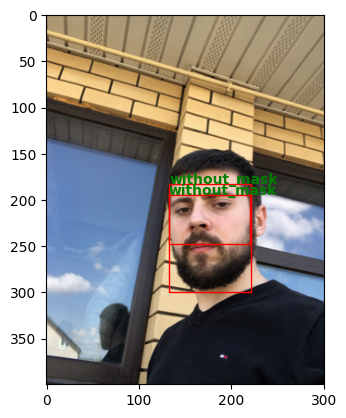

Target


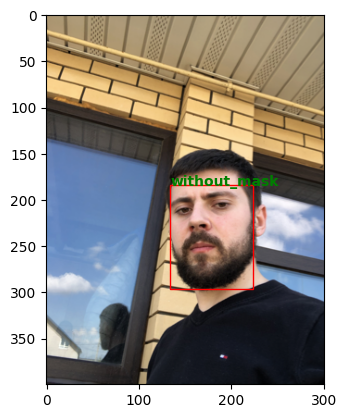

In [ ]:
print("Prediction")
plot_image(test_img[0], preds)
print("Target")
plot_image(test_img[0], test_annotations)

Prediction


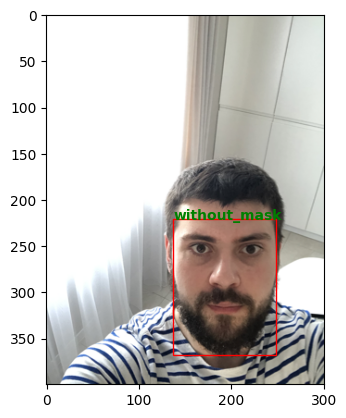

Target


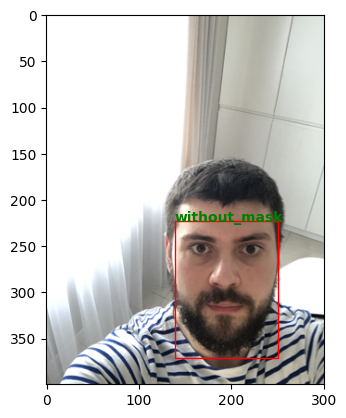

In [ ]:
print("Prediction")
plot_image(test_img[0], preds)
print("Target")
plot_image(test_img[0], test_annotations)

Prediction


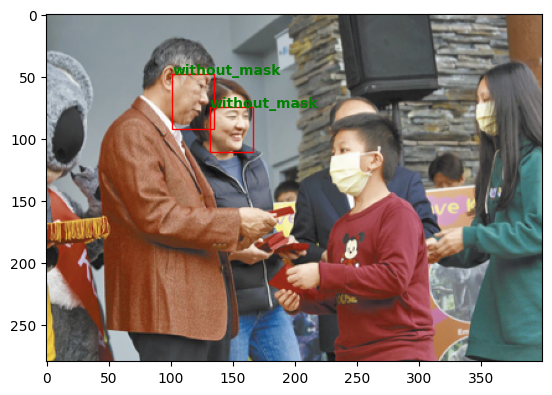

Target


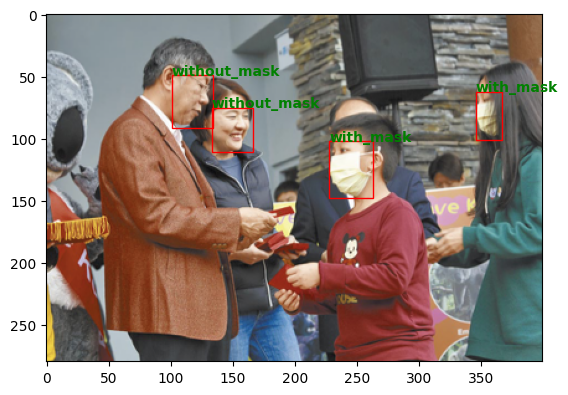

In [ ]:
print("Prediction")
plot_image(test_img[0], preds)
print("Target")
plot_image(test_img[0], test_annotations)